# 1.0 Exploration des donnees (2010-2024)

Objectifs:
- Charger les donnees 2010-2024 et faire un EDA global.
- Relancer un EDA detaille sur 2022 pour selectionner les colonnes utiles au modele.

Sources:
- EEA CO2 cars emission dataset (2010-2024)

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


In [32]:
# Affichage pandas
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", None)

sns.set(style="whitegrid")


In [33]:
BASE = Path.cwd().parent
DATA_2010_2023 = BASE / "data/raw/final_2010_2023_data.csv"
DATA_2024 = BASE / "data/raw/previsionnal_2024_data.csv"
DATA_2022 = BASE / "data/raw/final_2022_data.csv"

paths_2010_2024 = [DATA_2010_2023, DATA_2024]

for p in paths_2010_2024 + [DATA_2022]:
    print(p, "exists:", p.exists())



c:\Users\timot\DataScience\DataProjects\Projet_Co2\data\raw\final_2010_2023_data.csv exists: True
c:\Users\timot\DataScience\DataProjects\Projet_Co2\data\raw\previsionnal_2024_data.csv exists: True
c:\Users\timot\DataScience\DataProjects\Projet_Co2\data\raw\final_2022_data.csv exists: True


## EDA global 2010-2024 (volumetrie)

Le dataset 2010-2024 est tres volumineux. On utilise un traitement par chunks pour:
- compter les lignes,
- estimer les taux de valeurs manquantes,
- analyser la distribution par annee.



In [34]:
CHUNKSIZE = 1_000_000
MAX_ROWS = None  # set a smaller number for a quick run


def iter_csv(paths, chunksize=CHUNKSIZE, usecols=None):
    for p in paths:
        for chunk in pd.read_csv(p, chunksize=chunksize, low_memory=False, usecols=usecols):
            yield chunk


def compute_global_stats(paths, max_rows=None):
    total_rows = 0
    na_counts = None
    year_counts = None

    for chunk in iter_csv(paths):
        if max_rows is not None and total_rows >= max_rows:
            break
        if max_rows is not None:
            remaining = max_rows - total_rows
            chunk = chunk.iloc[:remaining]

        total_rows += len(chunk)

        if na_counts is None:
            na_counts = chunk.isna().sum()
        else:
            na_counts += chunk.isna().sum()

        if "year" in chunk.columns:
            vc = chunk["year"].value_counts(dropna=False)
            year_counts = vc if year_counts is None else year_counts.add(vc, fill_value=0)

    na_pct = (na_counts / total_rows).sort_values(ascending=False)
    year_counts = year_counts.sort_index() if year_counts is not None else None
    return total_rows, na_pct, year_counts



rows (2010-2024): 91158167


De                      0.973575
Vf                      0.958054
Electric range (km)     0.899681
Ernedc (g/km)           0.897075
RLFI                    0.894517
z (Wh/km)               0.886615
ech                     0.825668
Erwltp (g/km)           0.733287
Fuel consumption        0.640287
IT                      0.627247
Date of registration    0.567108
MMS                     0.473048
Enedc (g/km)            0.412920
At2 (mm)                0.257635
At1 (mm)                0.250591
VFN                     0.242003
W (mm)                  0.239152
Mt                      0.221209
Ewltp (g/km)            0.208597
Mp                      0.076372
dtype: float64

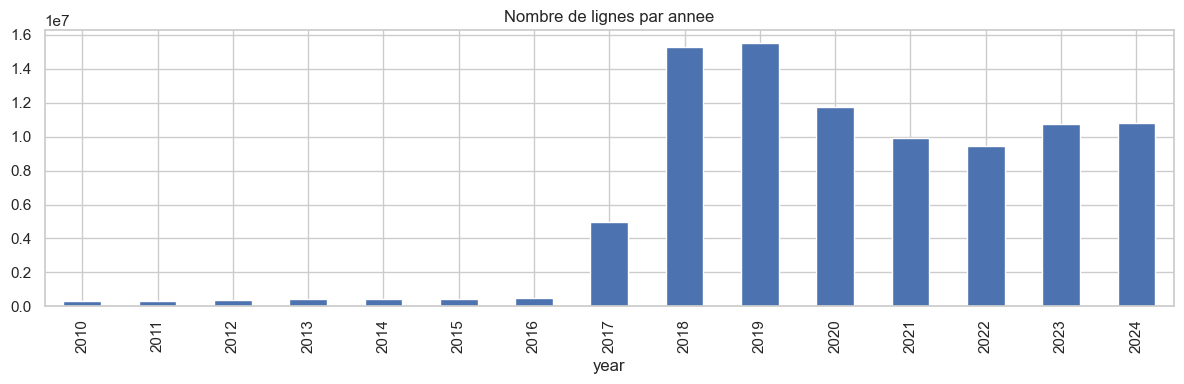

In [35]:
total_rows, na_pct, year_counts = compute_global_stats(paths_2010_2024, max_rows=MAX_ROWS)
print("rows (2010-2024):", total_rows)

display(na_pct.head(20))

if year_counts is not None:
    year_counts.plot(kind="bar", figsize=(12, 4), title="Nombre de lignes par annee")
    plt.tight_layout()
    plt.show()



In [36]:
# =========================
# Couverture par annee (WLTP/NEDC + colonnes cles)
# =========================
USECOLS = [
    "year",
    "Ewltp (g/km)", "Enedc (g/km)",
    "m (kg)", "ep (KW)", "ec (cm3)", "Electric range (km)"
]

def compute_year_completeness(paths, usecols, max_rows=None):
    total_rows = 0
    total = None
    non_na = None

    for chunk in iter_csv(paths, usecols=usecols):
        if max_rows is not None and total_rows >= max_rows:
            break
        if max_rows is not None:
            remaining = max_rows - total_rows
            chunk = chunk.iloc[:remaining]

        total_rows += len(chunk)

        chunk = chunk.dropna(subset=["year"])
        grp_total = chunk.groupby("year").size()
        total = grp_total if total is None else total.add(grp_total, fill_value=0)

        cols = [c for c in usecols if c != "year" and c in chunk.columns]
        grp_non_na = chunk.groupby("year")[cols].count()
        non_na = grp_non_na if non_na is None else non_na.add(grp_non_na, fill_value=0)

    completeness = non_na.div(total, axis=0).sort_index()
    return total.sort_index(), completeness

year_total, year_comp = compute_year_completeness(
    paths_2010_2024,
    usecols=USECOLS,
    max_rows=MAX_ROWS  # laisse None si tu veux tout
)

key_cols = [
    "Ewltp (g/km)", "Enedc (g/km)",
    "m (kg)", "ep (KW)", "ec (cm3)", "Electric range (km)"
]

display(year_comp[key_cols])


,Ewltp (g/km),Enedc (g/km),m (kg),ep (KW),ec (cm3),Electric range (km)
year,,,,,,
2010,0.000000,0.985901,0.983868,0.000000,0.913324,0.000000
2011,0.000000,0.996592,0.997132,0.603275,0.923397,0.000000
2012,0.000000,0.995568,0.998331,0.749007,0.941488,0.000000
2013,0.000000,0.996990,0.997552,0.822548,0.987950,0.000000
2014,0.000000,0.997504,0.999301,0.808826,0.993533,0.000000
2015,0.000000,0.998191,0.999514,0.828604,0.995259,0.000000
2016,0.000000,0.998413,0.999452,0.845767,0.994366,0.000000
2017,0.000488,0.999669,0.999947,0.977325,0.991211,0.000000
2018,0.299435,0.999078,0.999908,0.865497,0.990052,0.000000


In [37]:
key_cols = [
    "Ewltp (g/km)", "Enedc (g/km)",
    "m (kg)", "ep (KW)", "ec (cm3)", "Electric range (km)"
]


display(year_comp.reindex([2022, 2024])[key_cols])


,Ewltp (g/km),Enedc (g/km),m (kg),ep (KW),ec (cm3),Electric range (km)
year,,,,,,
2022,0.999113,0.171356,0.999987,0.986372,0.865198,0.202778
2024,0.998006,0.000000,0.999952,0.997822,0.854365,0.207759


In [38]:
import polars as pl

# =========================
# Scan lazy
# =========================
lf = pl.scan_csv([str(p) for p in paths_2010_2024], low_memory=True, infer_schema_length=1000)

# Schema fiable (metadata only)
schema = lf.collect_schema()
print(schema.names())

# =========================
# Stats en une passe
# =========================
stats = lf.select(
    pl.len().alias("n_rows"),
    pl.all().null_count().name.suffix("__missing"),
    pl.all().approx_n_unique().name.suffix("__nunique"),
).collect(streaming=True)

n_rows = stats["n_rows"][0]

missing_map = {
    c.replace("__missing", ""): int(stats[c][0])
    for c in stats.columns if c.endswith("__missing")
}
nunique_map = {
    c.replace("__nunique", ""): int(stats[c][0])
    for c in stats.columns if c.endswith("__nunique")
}

NUMERIC_DTYPES = {
    pl.Int8, pl.Int16, pl.Int32, pl.Int64,
    pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
    pl.Float32, pl.Float64
}

analysis = []
for col, dtype in schema.items():
    missing = missing_map.get(col, 0)
    nunique = nunique_map.get(col, 0)

    completeness = 1 - (missing / n_rows) if n_rows else 0
    cardinality_ratio = nunique / n_rows if n_rows else 0

    if dtype in NUMERIC_DTYPES:
        logical_type = "numeric"
    elif dtype == pl.Utf8:
        logical_type = "categorical"
    else:
        logical_type = "other"

    if logical_type == "numeric":
        subtype = "quantitative"
    elif logical_type == "categorical":
        if nunique < 15:
            subtype = "nominal"
        elif nunique < 50:
            subtype = "ordinal_possible"
        else:
            subtype = "high_cardinality"
    else:
        subtype = "unknown"

    drop_flag = completeness < 0.20

    analysis.append({
        "col": col,
        "dtype": str(dtype),
        "logical_type": logical_type,
        "subtype": subtype,
        "missing": missing,
        "completeness_ratio": float(completeness),
        "nunique": nunique,
        "cardinality_ratio": float(cardinality_ratio),
        "drop_flag_completeness": drop_flag
    })

df_analysis = pl.DataFrame(analysis)
df_analysis

df_analysis.to_pandas()

['ID', 'Country', 'VFN', 'Mp', 'Mh', 'Man', 'MMS', 'Tan', 'T', 'Va', 'Ve', 'Mk', 'Cn', 'Ct', 'Cr', 'r', 'm (kg)', 'Mt', 'Enedc (g/km)', 'Ewltp (g/km)', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ft', 'Fm', 'ec (cm3)', 'ep (KW)', 'z (Wh/km)', 'IT', 'Ernedc (g/km)', 'Erwltp (g/km)', 'De', 'Vf', 'Status', 'year', 'Date of registration', 'Fuel consumption ', 'ech', 'RLFI', 'Electric range (km)']


C:\Users\timot\AppData\Local\Temp\ipykernel_23148\428891854.py:19: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  ).collect(streaming=True)


,col,dtype,logical_type,subtype,missing,completeness_ratio,nunique,cardinality_ratio,drop_flag_completeness
0,ID,Int64,numeric,quantitative,0,1.000000,51600833,5.660583e-01,False
1,Country,String,categorical,ordinal_possible,1193,0.999987,29,3.181284e-07,False
2,VFN,String,categorical,high_cardinality,22060248,0.758000,17737,1.945739e-04,False
3,Mp,String,categorical,high_cardinality,6961959,0.923628,58,6.362568e-07,False
4,Mh,String,categorical,high_cardinality,0,1.000000,282,3.093524e-06,False
5,Man,String,categorical,high_cardinality,999,0.999989,617,6.768456e-06,False
6,MMS,String,categorical,high_cardinality,43106242,0.527127,9576,1.050482e-04,False
7,Tan,String,categorical,high_cardinality,692630,0.992402,59392,6.515269e-04,False
8,T,String,categorical,high_cardinality,88189,0.999033,22682,2.488203e-04,False
9,Va,String,categorical,high_cardinality,246106,0.997300,63481,6.963830e-04,False


## Conclusion EDA global (2010-2024)

- Volumetrie tres elevee (rapport: ~91M lignes / 40 colonnes).
- Couverture des colonnes variable selon les annees; WLTP devient dominant.
- 2024 (previsionnel) est moins complet sur la cible WLTP.
- 2022 combine volume et meilleure couverture WLTP.

=> On focalise l'analyse detaillee sur 2022 (VF) pour une selection robuste des variables.


## EDA 2022 (VF)



In [39]:
NROWS = None  # set for quick run

df_2022 = pd.read_csv(DATA_2022, low_memory=False, nrows=NROWS)
print("shape:", df_2022.shape)

df_2022.head()



shape: (9479544, 40)


,ID,Country,VFN,Mp,Mh,Man,MMS,Tan,T,Va,Ve,Mk,Cn,Ct,Cr,r,m (kg),Mt,Enedc (g/km),Ewltp (g/km),W (mm),At1 (mm),At2 (mm),Ft,Fm,ec (cm3),ep (KW),z (Wh/km),IT,Ernedc (g/km),Erwltp (g/km),De,Vf,Status,year,Date of registration,Fuel consumption,ech,RLFI,Electric range (km)
0,73867100,NO,IP-MEB31AZ_A0_1913-TMB-1,VOLKSWAGEN,SKODA,SKODA AUTO AS,NaN,e8*2007/46*0416*09,NY,ACEBJAL1FX2,O0PE1PE1MH002MN31AA,SKODA,ENYAQ 80,M1,M1,1,2154.0,NaN,0.0,0.0,2770.0,1599.0,1577.0,electric,E,NaN,150.0,168.0,NaN,NaN,NaN,NaN,NaN,F,2022,2022-10-27,NaN,NaN,NaN,514.0
1,73867101,NO,IP-MEB31AZ_A0_1900-TMB-1,VOLKSWAGEN,SKODA,SKODA AUTO AS,NaN,e8*2007/46*0416*09,NY,ACX1EBL1RX1,D0AE1AE1G1Z01MN01AA,SKODA,ENYAQ 80X,M1,M1,1,2200.0,NaN,0.0,0.0,2770.0,1599.0,1577.0,electric,E,NaN,80.0,174.0,NaN,NaN,NaN,NaN,NaN,F,2022,2022-10-19,NaN,NaN,NaN,499.0
2,73867102,NO,NaN,NaN,VOLVO,VOLVO CAR CORPORATION,NaN,e9*2007/46*3146*15,X,XKED,XKEDVE0?,VOLVO,C40,M1,M1,1,2185.0,2334.0,0.0,0.0,2702.0,1601.0,1608.0,electric,E,NaN,150.0,201.0,NaN,NaN,NaN,NaN,NaN,F,2022,2022-11-04,NaN,NaN,NaN,445.0
3,73867103,NO,IP-0000783-WBA-1,BMW,BMW AG,BAYERISCHE MOTOREN WERKE AG,NaN,e1*2018/858*00109*01,BMWi-N,11CF,0AW50000,BMW,iX xDrive40,M1,M1,1,2440.0,2635.0,0.0,0.0,3000.0,1679.0,1709.0,electric,E,NaN,NaN,209.0,NaN,NaN,NaN,NaN,NaN,F,2022,2022-10-27,NaN,NaN,NaN,399.0
4,73867104,NO,IP-0000782-WBA-1,BMW,BMW AG,BAYERISCHE MOTOREN WERKE AG,NaN,e1*2018/858*00109*01,BMWi-N,21CF,0AW50000,BMW,iX xDrive50,M1,M1,1,2585.0,2790.0,0.0,0.0,3000.0,1677.0,1706.0,electric,E,NaN,NaN,213.0,NaN,NaN,NaN,NaN,NaN,F,2022,2022-10-26,NaN,NaN,NaN,593.0


In [40]:
df_2022.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9479544 entries, 0 to 9479543
Data columns (total 40 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Country               object 
 2   VFN                   object 
 3   Mp                    object 
 4   Mh                    object 
 5   Man                   object 
 6   MMS                   float64
 7   Tan                   object 
 8   T                     object 
 9   Va                    object 
 10  Ve                    object 
 11  Mk                    object 
 12  Cn                    object 
 13  Ct                    object 
 14  Cr                    object 
 15  r                     int64  
 16  m (kg)                float64
 17  Mt                    float64
 18  Enedc (g/km)          float64
 19  Ewltp (g/km)          float64
 20  W (mm)                float64
 21  At1 (mm)              float64
 22  At2 (mm)              float64
 23  Ft     

In [41]:
missing_2022 = df_2022.isna().mean().sort_values(ascending=False)
display(missing_2022.head(20))

dup_count = df_2022.duplicated().sum()
print("duplicates:", dup_count)



MMS                     1.000000
Ernedc (g/km)           1.000000
ech                     1.000000
De                      1.000000
RLFI                    1.000000
Vf                      1.000000
Enedc (g/km)            0.828644
Electric range (km)     0.797222
z (Wh/km)               0.774318
Erwltp (g/km)           0.345459
IT                      0.326641
Fuel consumption        0.147397
ec (cm3)                0.134802
Mp                      0.065458
At2 (mm)                0.018782
Mt                      0.017803
Date of registration    0.017017
At1 (mm)                0.015977
ep (KW)                 0.013628
VFN                     0.012509
dtype: float64

duplicates: 0


In [42]:
target = "Ewltp (g/km)"
print("Ewltp missing %:", df_2022[target].isna().mean())
print("Enedc missing %:", df_2022["Enedc (g/km)"].isna().mean())



Ewltp missing %: 0.0008872789661612415
Enedc missing %: 0.8286439727480562


In [43]:
# =========================
# Qualite cible 2022
# =========================
target = "Ewltp (g/km)"
s = df_2022[target].dropna()

display(s.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))
print("pct_zero:", (s == 0).mean())
print("pct_negative:", (s < 0).mean())


count    9.471133e+06
mean     1.082588e+02
std      5.827702e+01
min      0.000000e+00
1%       0.000000e+00
5%       0.000000e+00
50%      1.230000e+02
95%      1.850000e+02
99%      2.440000e+02
max      7.300000e+02
Name: Ewltp (g/km), dtype: float64

pct_zero: 0.13490402890551742
pct_negative: 0.0


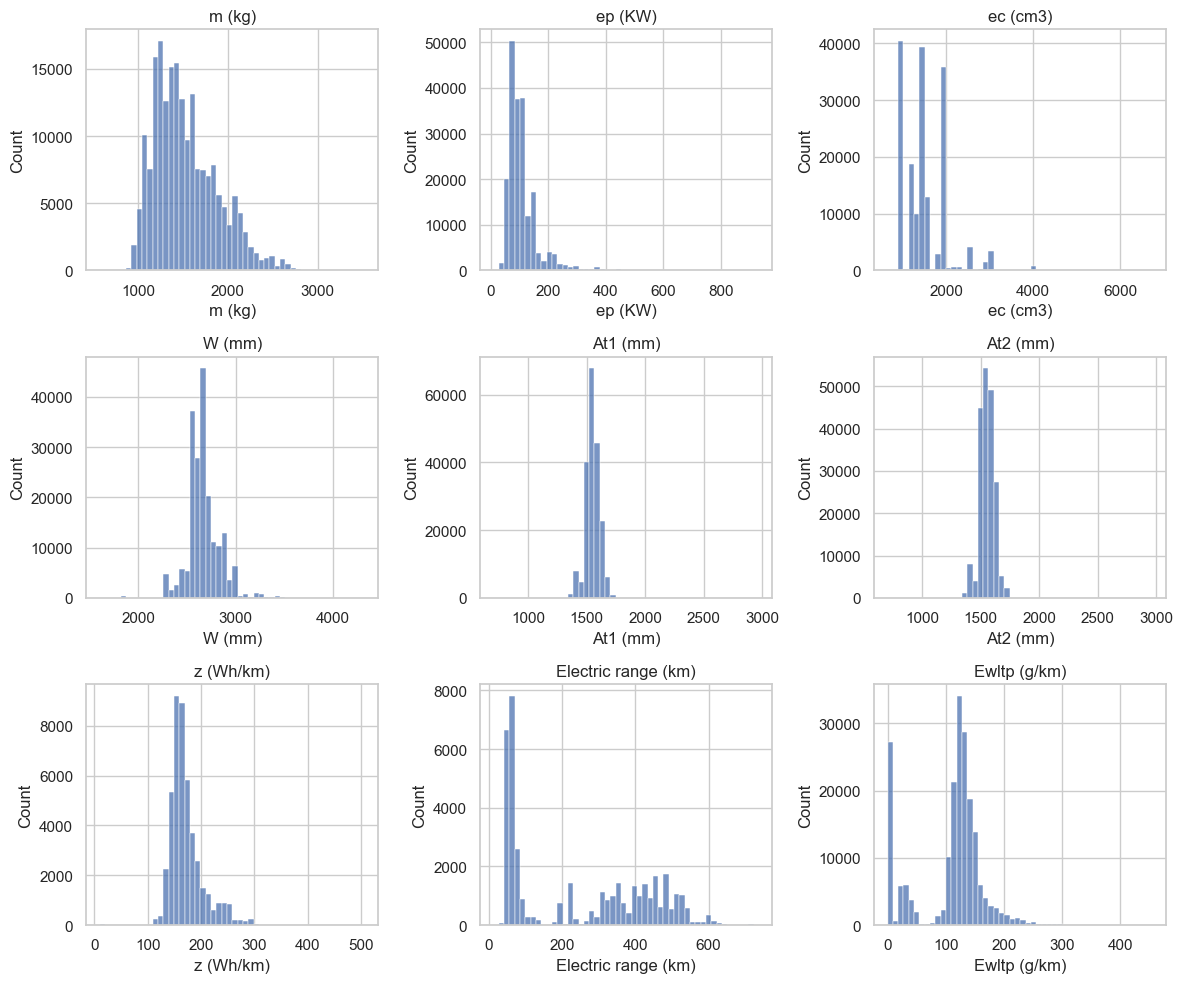

In [44]:
num_focus = [
    "m (kg)", "ep (KW)", "ec (cm3)", "W (mm)",
    "At1 (mm)", "At2 (mm)", "z (Wh/km)",
    "Electric range (km)", target
]

if len(df_2022) > 200000:
    df_sample = df_2022[num_focus].sample(n=200000, random_state=42)
else:
    df_sample = df_2022[num_focus]

fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten()
for i, col in enumerate(num_focus):
    sns.histplot(df_sample[col], bins=50, ax=axes[i], kde=False)
    axes[i].set_title(col)
plt.tight_layout()
plt.show()



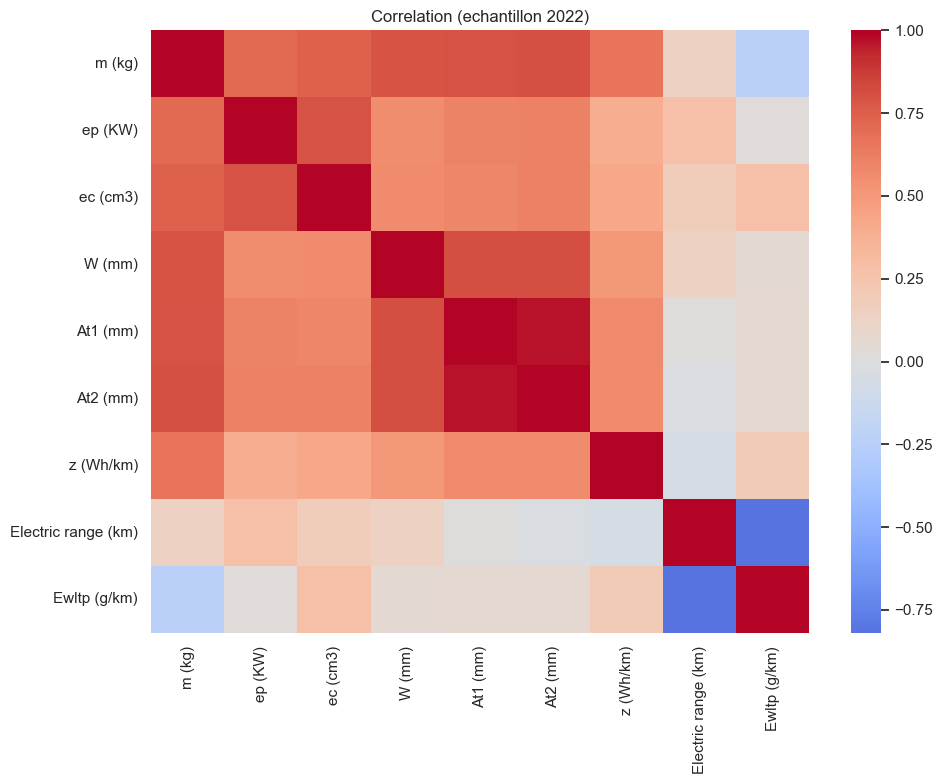

In [45]:
corr = df_sample.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation (echantillon 2022)")
plt.tight_layout()
plt.show()



Correlations principales visibles pour orienter l'analyse.


In [46]:
for col in ["Ft", "Fm", "Man", "Mk"]:
    if col in df_2022.columns:
        display(df_2022[col].value_counts().head(15))



Ft
petrol             5159284
diesel             1841731
electric           1276456
petrol/electric     857699
lpg                 243854
diesel/electric      42016
e85                  38907
ng                   18254
hydrogen              1238
unknown                105
Name: count, dtype: int64

Fm
M    4825606
H    2218070
E    1276456
P     899715
B     245523
F      14069
Name: count, dtype: int64

Man
VOLKSWAGEN AG                  1025304
STELLANTIS AUTO SAS             837258
RENAULT SAS                     702942
BAYERISCHE MOTOREN WERKE AG     625233
MERCEDES-BENZ AG                553710
TOYOTA MOTOR EUROPE NV SA       487934
SKODA AUTO AS                   470789
AUDI AG                         464520
STELLANTIS EUROPE SPA           431123
FORD WERKE GMBH                 404174
AUTOMOBILE DACIA SA             308146
SEAT SA                         298616
AUTOMOBILES CITROEN             225516
KIA SLOVAKIA SRO                221023
KIA CORPORATION                 213232
Name: count, dtype: int64

Mk
TOYOTA            658429
PEUGEOT           586833
RENAULT           563252
VOLKSWAGEN. VW    546291
MERCEDES-BENZ     535412
BMW               500516
AUDI              484141
SKODA             453529
DACIA             448019
KIA               434351
HYUNDAI           433271
FORD              403060
VOLKSWAGEN        399400
CITROEN           347695
FIAT              344415
Name: count, dtype: int64

Categories dominantes observees pour les variables qualitatives.


In [47]:
# =========================
# Stabilité des distributions (echantillon)
# =========================
SAMPLE_MAX = 200_000
SAMPLE_FRAC = 0.002  # ~0.2% par chunk
USECOLS_DRIFT = ["year", "m (kg)", "ep (KW)", "ec (cm3)", "Ewltp (g/km)"]

def sample_dataset(paths, usecols, sample_frac=0.002, max_sample=200_000):
    parts = []
    total = 0
    for chunk in iter_csv(paths, usecols=usecols):
        take = chunk.sample(frac=sample_frac, random_state=42)
        parts.append(take)
        total += len(take)
        if total >= max_sample:
            break
    return pd.concat(parts, ignore_index=True)

df_sample_global = sample_dataset(paths_2010_2024, usecols=USECOLS_DRIFT,
                                  sample_frac=SAMPLE_FRAC, max_sample=SAMPLE_MAX)

df_sample_global["is_2022"] = df_sample_global["year"] == 2022

summary = (
    df_sample_global.groupby("is_2022")[["m (kg)", "ep (KW)", "ec (cm3)", "Ewltp (g/km)"]]
    .agg(["mean", "median"])
)
display(summary)


m (kg)             ep (KW)            ec (cm3)          \
                mean  median        mean median         mean  median   
is_2022                                                                
False    1462.091957  1395.0  104.656265   94.0  1552.193510  1498.0   
True     1527.668548  1455.0  109.517577   96.0  1542.852418  1498.0   

        Ewltp (g/km)         
                mean median  
is_2022                      
False     125.173806  133.0  
True      107.855672  123.0

Comparaison rapide 2022 vs autres annees sur variables numeriques.


## Selection des colonnes utiles

Objectif: identifier les colonnes candidates a exclusion (sans appliquer de filtre ici).
On supprimera au preprocessing dans un notebook séparé:
- les colonnes de fuite cible (ex: Fuel consumption si la cible est Ewltp),
- les colonnes NEDC obsoletes,
- les colonnes administratives/ID,
- les colonnes avec trop de NA.


In [48]:
high_missing = missing_2022[missing_2022 > 0.8].index.tolist()

drop_leakage = [
    "Fuel consumption",
    "Enedc (g/km)",
    "Ernedc (g/km)",
    "Erwltp (g/km)"
]

drop_admin = [
    "ID", "VFN", "Mp", "Mh", "MMS", "Tan", "T", "Va", "Ve", "Mk", "Cn",
    "Ct", "Cr", "r", "IT", "Status", "Date of registration", "De", "Vf", "ech", "RLFI"
]

drop_cols_raw = sorted(set(high_missing + drop_leakage + drop_admin))
col_lookup = {c.strip(): c for c in df_2022.columns}

drop_cols = [col_lookup.get(c, c) for c in drop_cols_raw]
drop_cols = [c for c in drop_cols if c in df_2022.columns]

print("drop cols (candidats, sans application):", drop_cols)


drop cols (candidats, sans application): ['Cn', 'Cr', 'Ct', 'Date of registration', 'De', 'Enedc (g/km)', 'Ernedc (g/km)', 'Erwltp (g/km)', 'Fuel consumption ', 'ID', 'IT', 'MMS', 'Mh', 'Mk', 'Mp', 'RLFI', 'Status', 'T', 'Tan', 'VFN', 'Va', 'Ve', 'Vf', 'ech', 'r']


## Conclusion 2022 (VF)

- La cible Ewltp (g/km) est suffisamment renseignee en 2022.
- Les variables physiques/energetiques ont des distributions exploitables.
- Les colonnes admin/obsoletes sont candidates a exclusion.